### LOAD AND PLOT DATA FROM A SESSION #### 
This notebook should run from within the iblenv.
The functions are taken from the source code of the IBL library. 

For documentation check:

https://int-brain-lab.github.io/iblenv/_autosummary/ibllib.io.raw_data_loaders.html?highlight=raw%20data%20loaders#module-ibllib.io.raw_data_loaders



In [5]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
# @Author: Mora Ogando
# @Date: Sunday, July 4th 2021, 1:28:46 pm
"""

Raw Data Loader functions for PyBpod rig

Module contains one loader function per raw datafile
"""
#import things
import json
import logging
import wave
from datetime import datetime
from pathlib import Path
from typing import Union
import matplotlib.pyplot as plt

import itertools
from glob import glob
import pickle

import numpy as np
import pandas as pd

#from ibllib.io import jsonable
from ibllib.io import raw_data_loaders
from ibllib.misc import version
# Helpers Mori

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def appendColumnToDF(df,OneDArray,columnName,appendTO):
# the number of elements in the 1dArray and the number of elements in the appendTO column (i.e.: 'cell') has to match.
    # 1. create a pandas series with your array
    series = pd.Series(list(OneDArray),name=columnName)
    # 2. create the index (has to match the index in "appendTO")
    index= pd.Series(np.arange(0,len(OneDArray)),name=appendTO)
    # 3. make a DataFrame with these 
    appendDF = pd.DataFrame(series,index)
    
    #4. join it onto a new dataframe
    try:
        df.reset_index(inplace=True)
    except:
        pass
    df2 = df.set_index([appendTO])
    df2 = df.join(appendDF,on=appendTO,how='left')
    return df2

def saveTrialWiseInfo_inServer(session_path):
    #Load data 
    session_data = raw_data_loaders.load_data(session_path)
    settings =raw_data_loaders.load_settings(session_path)
    encoder_events = raw_data_loaders.load_encoder_events(session_path, settings=False)
    encoder_positions =raw_data_loaders.load_encoder_positions(session_path, settings=False)
    encoder_trial_info = raw_data_loaders.load_encoder_trial_info(session_path)

    # correct responses is a boolean list of len = number of trials.
    correct_responses = [session_data[i]['trial_correct'] for i in range(len(session_data))]

    # append correct responses to trial info

    # ((the number of elements in the 1dArray and the number of elements in the appendTO column (i.e.: 'cell') has to match.))
    OneDArray = correct_responses
    columnName = 'correct'
    appendTO = 'trial_num'
    trialInfo= appendColumnToDF(encoder_trial_info,OneDArray,columnName,appendTO)

    # get the time in the same units and merge the encoder position with the trialInfo dataFrames
    trialInfo['relative_time_ms'] = (pd.to_datetime(trialInfo.bns_ts).values -pd.to_datetime(trialInfo.bns_ts).values[0])/1000000
    trialInfo['relative_time_ms'] = trialInfo.relative_time_ms.astype(np.int64) 
    encoder_positions['relative_time_ms'] = (encoder_positions.re_ts.values- encoder_positions.re_ts.values[0])/1000
    merged_df = pd.merge(trialInfo, encoder_positions, on = 'relative_time_ms',how='outer')

    # save

    name = 'behavior_analysis_df'

    merged_df.to_csv(path + name + '.csv')
    out_path = r'W:\Satsuma\Mora//' + path.split('C:\\')[-1]
    out_path 
    import os
    try:
        os.makedirs(out_path)
        print('created a new results folder')
    except:
        print('couldnt make folder')
        print(out_path)

    merged_df.to_csv(out_path + name + '.csv')
    trialInfo.to_csv(out_path + 'trialInfo.csv')
    return  merged_df,trialInfo

### Merge session info and save it in the server ###

In [17]:
basePath = r'C:\iblrig_data\Subjects//'
serverPath = r'Z:\moraogando\IBLdata\Current_Mice_(Mike)//'
m503 = 'MBOT77_503'
m513 = 'MBOT77_513'
date = '2023-06-13'
session = '001'

session_path = basePath + m503 + '//' + date + '//' + session

#Load data 
session_data = raw_data_loaders.load_data(session_path)
settings =raw_data_loaders.load_settings(session_path)
encoder_events = raw_data_loaders.load_encoder_events(session_path, settings=False)
encoder_positions =raw_data_loaders.load_encoder_positions(session_path, settings=False)
encoder_trial_info = raw_data_loaders.load_encoder_trial_info(session_path)

# correct responses is a boolean list of len = number of trials.
correct_responses = [session_data[i]['trial_correct'] for i in range(len(session_data))]

# append correct responses to trial info

# ((the number of elements in the 1dArray and the number of elements in the appendTO column (i.e.: 'cell') has to match.))
OneDArray = correct_responses
columnName = 'correct'
appendTO = 'trial_num'
trialInfo= appendColumnToDF(encoder_trial_info,OneDArray,columnName,appendTO)

# # get the time in the same units and merge the encoder position with the trialInfo dataFrames
trialInfo['relative_time_ms'] = (pd.to_datetime(trialInfo.bns_ts).values -pd.to_datetime(trialInfo.bns_ts).values[0])/1000000
trialInfo['relative_time_ms'] = trialInfo.relative_time_ms.astype(np.int64) 
encoder_positions['relative_time_ms'] = (encoder_positions.re_ts.values- encoder_positions.re_ts.values[0])/1000
merged_df = pd.merge(trialInfo, encoder_positions, on = 'relative_time_ms',how='outer')

2023-06-25 20:21:12.489 WARNING  [raw_data_loaders.py:613] _iblrig_encoderPositions.raw.ssv rotary encoder timestamps swapped at index: 51276  Z:\moraogando\IBLdata\Current_Mice_(Mike)\MBOT77_503\2023-06-18\001\raw_behavior_data\_iblrig_encoderPositions.raw.ssv
C:\ProgramData\Anaconda3\envs\iblenv\lib\site-packages\pandas\core\reshape\merge.py:1100: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [18]:
only_contrasts_and_accuracy= trialInfo[["stim_contrast", "correct"]].dropna()
only_contrasts_and_accuracy['correct'] = only_contrasts_and_accuracy['correct'].astype('int')
only_contrasts_and_accuracy.groupby('stim_contrast').agg(np.mean)


,correct
stim_contrast,
0.0000,0.588235
0.0625,0.586207
0.1250,0.652174
0.2500,0.707317
0.5000,0.666667
1.0000,0.850000


In [19]:
trialInfo

,index,trial_num,stim_pos_init,stim_contrast,stim_freq,stim_angle,stim_gain,stim_sigma,stim_phase,bns_ts,correct,relative_time_ms
0,0,1,1,1.00,0.06,-0.785398,4,10000,0.000000,2023-06-18T19:25:01.6889472-07:00,True,0
1,1,2,1,1.00,0.06,0.785398,4,10000,170.283077,2023-06-18T19:25:10.1936768-07:00,False,8504
2,2,3,-1,0.50,0.06,-0.785398,4,10000,232.936498,2023-06-18T19:25:14.5259776-07:00,True,12837
3,3,4,-1,0.50,0.06,-0.785398,4,10000,151.969428,2023-06-18T19:25:23.6934528-07:00,True,22004
4,4,5,-1,0.50,0.06,-0.785398,4,10000,115.620759,2023-06-18T19:25:27.8950656-07:00,False,26206
...,...,...,...,...,...,...,...,...,...,...,...,...
157,157,158,1,0.25,0.06,0.785398,4,10000,342.381428,2023-06-18T19:41:17.0643200-07:00,True,975375
158,158,159,1,0.25,0.06,0.785398,4,10000,289.060381,2023-06-18T19:41:46.0474496-07:00,True,1004358
159,159,160,-1,1.00,0.06,-0.785398,4,10000,83.364890,2023-06-18T19:41:50.5383552-07:00,False,1008849
160,160,161,-1,0.50,0.06,-0.785398,4,10000,186.861818,2023-06-18T19:41:55.9065728-07:00,NaN,1014217


### Make behavior stim conditions to synchronize holography and pybpod ###

In [21]:
# verify that the stim angle and encoder position have matching time scales
ax = merged_df.plot(x="relative_time_ms", y="stim_angle", legend=False)
ax2 = ax.twinx()
merged_df.plot(x="relative_time_ms", y="re_pos", ax=ax2, legend=False, color="r")
ax.figure.legend()
ax.set_xlim(0,200000)
plt.show()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

fraction correct for session was 0.6770186335403726
fraction correct for angle 0 = 0.5392156862745098
fraction correct for angle 90 = 0.9152542372881356


(0.0, 1.0)

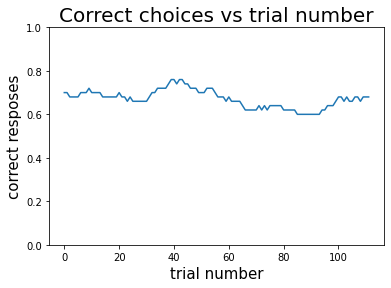

In [22]:
def single_line():
    window = 50# how many trials to average 
    firsttrial=0
    lasttrial=4000
    print('fraction correct for session ' + 'was ' + str(np.mean(correct_responses[:lasttrial])))
    # get the info of which angle was shown at each trial 
    stim_angle= [session_data[i]['stim_angle'] for i in range(len(session_data[:lasttrial]))]

    deg90 = np.where(np.array(stim_angle)>0)[0][firsttrial:lasttrial] # array of trial numbers where the angle was more than 0
    deg0= np.where(np.array(stim_angle)<=0)[0][firsttrial:lasttrial] # array of trial numbers where the angle was 0
    correct90 = [correct_responses[i] for i in deg90]#@[firsttrial:lasttrial]
    correct0 = [correct_responses[i] for i in deg0]#[firsttrial:lasttrial]

    #get the % of correct responses for each angle across the whole session
    print('fraction correct for angle 0 = ' + str(np.nanmean(correct0)))
    print('fraction correct for angle 90 = ' + str(np.mean(correct90)))


    # plot a moving average of the correct responses across trials for a given window
    plt.plot(moving_average(correct_responses[firsttrial:lasttrial],window))
    plt.title('Correct choices vs trial number',fontsize = 20)
    plt.xlabel('trial number',fontsize = 15)
    plt.ylabel('correct responses',fontsize = 15)

    plt.ylim(0,1)

In [23]:
correct_responses

[True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 Tr

In [24]:
moving_average(correct_responses[firsttrial:lasttrial],window)

array([0.7 , 0.7 , 0.68, 0.68, 0.68, 0.68, 0.7 , 0.7 , 0.7 , 0.72, 0.7 ,
       0.7 , 0.7 , 0.7 , 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.7 , 0.68,
       0.68, 0.66, 0.68, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.68, 0.7 ,
       0.7 , 0.72, 0.72, 0.72, 0.72, 0.74, 0.76, 0.76, 0.74, 0.76, 0.76,
       0.74, 0.74, 0.72, 0.72, 0.72, 0.7 , 0.7 , 0.7 , 0.72, 0.72, 0.72,
       0.7 , 0.68, 0.68, 0.68, 0.66, 0.68, 0.66, 0.66, 0.66, 0.66, 0.64,
       0.62, 0.62, 0.62, 0.62, 0.62, 0.64, 0.62, 0.64, 0.62, 0.64, 0.64,
       0.64, 0.64, 0.64, 0.62, 0.62, 0.62, 0.62, 0.62, 0.6 , 0.6 , 0.6 ,
       0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.62, 0.62, 0.64, 0.64, 0.64,
       0.66, 0.68, 0.68, 0.66, 0.68, 0.66, 0.66, 0.68, 0.68, 0.66, 0.68,
       0.68, 0.68])

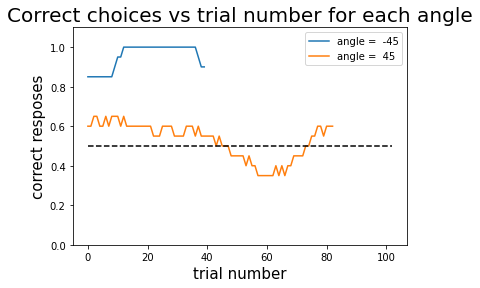

In [25]:
#plot % of correct responses for each angle across the whole session with a rolling average
# if correct responses are higher for one of the gratings, this indicates a bias.
def double_line():
    window = 20
    plt.plot(moving_average(correct90,window))
    plt.plot(moving_average(correct0,window))
    plt.title('Correct choices vs trial number for each angle',fontsize = 20)
    plt.xlabel('trial number',fontsize = 15)
    plt.ylabel('correct resposes',fontsize = 15)
    plt.ylim(0,1.1)
    xmax = max(len(correct90),len(correct0))
    plt.hlines(0.5, 0, xmax, colors='black',linestyles='dashed')
    plt.legend(['angle =  ' + str(i) for i in [-45,45]])
    plt.savefig(session_path + '//Correct_vs_trial_per_angle')


In [26]:
session_path

'Z:\\moraogando\\IBLdata\\Current_Mice_(Mike)//MBOT77_503//2023-06-18//001'

In [27]:
# compute the bias:
def bias():
    # bias computation for repeat_on_error on sessions
    # %Left = ([N trials where angle presented was 0 & mouse was correct] + [N trials where angle presented was 90 and mouse was incorrect])/NtotalTrials
    percent_left = (len(correct0) + (len(deg90)-len(correct90)))/(len(deg0)+len(deg90))
    # Absolute bias = np.abs(0.5 - %Left)
    abs_bias = np.abs(0.5 - percent_left)

    # bias computation for repeat_on_error off sessions:

    # bar chart of % abs bias
    # categories = ['repeat_on_error on', 'repeat_on_error off']
    # values = [abs_bias_on, abs_bias_off]
    # plt.bar(categories, values)

    print('Percent Left Choices:')
    print(percent_left)
    print('Percent Absolute Bias:')
    print(abs_bias)

Percent Left Choices:
0.6335403726708074
Percent Absolute Bias:
0.13354037267080743


In [16]:
print(len(deg90))
print(len(deg0))

103
119


In [164]:
import math
math.pi/2

1.5707963267948966

In [ ]:
1*0.015

In [ ]:
0.25*0.05

In [ ]:
math.degrees(0.25*0.05)#%180

In [ ]:
math.degrees(0.25/0.05)%180